In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as pl
import os
import PIL as pil
import pathlib as plb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

In [3]:
dir = tf.keras.utils.get_file('flower_photos', origin = url, untar = True)      # 해당 링크에서 압축된 데이터를 가져와 압축을 풀고 그 경로를 반환 (텍스트)

In [4]:
dir = plb.Path(dir)                                                             # 텍스트로 된 경로를 탐색 가능한 디렉토리 객체로
cnt = len(list(dir.glob('*/*.jpg')))                                            # len(list(dir의 안의 모든 폴더 아래의 모든 .jpg 파일 탐색))

In [5]:
Rose = list(dir.glob('roses/*.jpg'))
Daisy = list(dir.glob('daisy/*.jpg'))
Sunflower = list(dir.glob('sunflowers/*.jpg'))
Dandelion = list(dir.glob('dandelion/*.jpg'))
Tulip = list(dir.glob('tulips/*.jpg'))

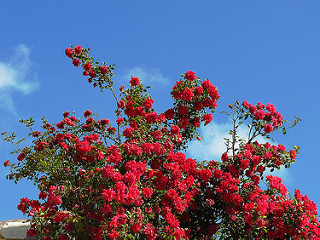

In [6]:
pil.Image.open(Rose[0])                                                         # 해당 경로의 이미지 오픈

In [7]:
batch = 32
img_size = (400, 400)

train = tf.keras.preprocessing.image_dataset_from_directory(
    
  dir, validation_split = 0.2, subset = 'training', seed = 123, image_size = img_size, batch_size = batch

)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    
  dir, validation_split = 0.2, subset = 'validation', seed = 123, image_size = img_size, batch_size = batch

)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
cn = train.class_names

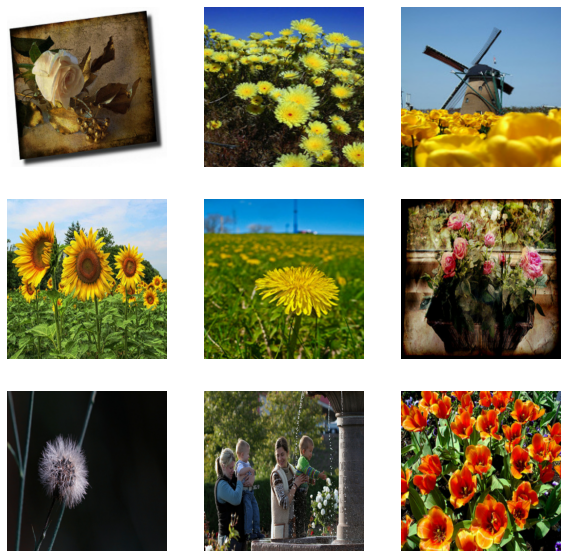

In [9]:
pl.figure(figsize = (10, 10))

for img, lbl in train.take(1):                                                  # 배치 사이즈 단위로 1개 가져온다.
  for i in range(9):

    pl.subplot(3, 3, i+1)
    pl.imshow(img[i].numpy().astype('uint8'))                                   # 이미지를 정상적으로 출력하기 위해 변환
    pl.axis('off')

In [10]:
# 병렬 처리

autotune = tf.data.experimental.AUTOTUNE                                        # 버퍼 공간 획득

train = train.cache().shuffle(1000).prefetch(buffer_size = autotune)            # 버퍼 공간을 활용하여 미리 이미지 처리 및 셔플이 되도록 함.
valid = valid.cache().prefetch(buffer_size = autotune)

In [11]:
nClass = 5

In [12]:
md = Sequential([                                                               # 모델 생성
    
    layers.experimental.preprocessing.Rescaling(1/255, input_shape = (400, 400, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(nClass, activation = 'softmax')

])

md.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
md.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      1

In [13]:
hist = md.fit(train, validation_data = valid, epochs = 15, verbose = 1)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


92/92 [==============================] - 32s 146ms/step - loss: 1.3759 - accuracy: 0.4745 - val_loss: 1.0798 - val_accuracy: 0.5695
Epoch 2/15
92/92 [==============================] - 10s 109ms/step - loss: 0.9396 - accuracy: 0.6390 - val_loss: 0.9254 - val_accuracy: 0.6308
Epoch 3/15
92/92 [==============================] - 10s 112ms/step - loss: 0.7095 - accuracy: 0.7384 - val_loss: 0.9955 - val_accuracy: 0.6144
Epoch 4/15
92/92 [==============================] - 10s 109ms/step - loss: 0.4047 - accuracy: 0.8614 - val_loss: 1.0660 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 10s 110ms/step - loss: 0.1718 - accuracy: 0.9414 - val_loss: 1.6464 - val_accuracy: 0.5858
Epoch 6/15
92/92 [==============================] - 10s 110ms/step - loss: 0.0676 - accuracy: 0.9785 - val_loss: 1.5992 - val_accuracy: 0.6076
Epoch 7/15
92/92 [==============================] - 10s 110ms/step - loss: 0.0357 - accuracy: 0.9918 - val_loss: 2.0976 - val_accuracy: 0.6076
Epoch 8/15

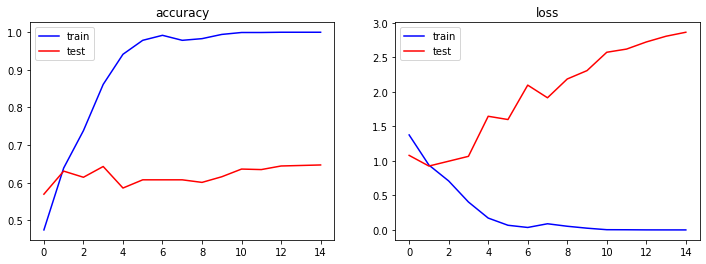

In [14]:
accuracy = hist.history['accuracy']         # 그래프 그리기
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

pl.figure(figsize = (12,4))

pl.subplot(1, 2, 1)
pl.plot(accuracy, 'b-', label="train")
pl.plot(val_accuracy, 'r-', label="test")
pl.legend()
pl.title('accuracy')

pl.subplot(1, 2, 2)
pl.plot(loss, 'b-', label="train")
pl.plot(val_loss, 'r-', label="test")
pl.legend()
pl.title('loss')

pl.show()